In [ ]:
!pip install rasterio --quiet
!pip install albumentations --quiet
!pip install segmentation_models_pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00


In [1]:
import zipfile
import os

# Path to your uploaded ZIP file in Colab sidebar
zip_path = "/content/data-20250714T200605Z-1-001.zip"
extract_path = "/content/data"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data unzipped to:", extract_path)


Data unzipped to: /content/data


In [2]:
import os
import numpy as np
from PIL import Image
import shutil

# Set input directories for labels (masks) and images
label_dir = "/content/data/data/labels"
image_dir = "/content/data/data/images"

# Set output directories for filtered images and labels
filtered_images = "/content/data/filtered/images"
filtered_labels = "/content/data/filtered/labels"

# Create output directories if they don't exist
os.makedirs(filtered_images, exist_ok=True)
os.makedirs(filtered_labels, exist_ok=True)

# Get a sorted list of all mask files in the label directory
mask_files = sorted(os.listdir(label_dir))
count = 0  # Counter for how many valid image-mask pairs are found

# Loop through each mask file
for mask_file in mask_files:
    mask_path = os.path.join(label_dir, mask_file)  # Full path to the mask file
    mask = np.array(Image.open(mask_path))          # Load mask as a numpy array

    # Check if the mask contains any water pixels (non-zero values)
    if np.sum(mask > 0):
        # Get the corresponding image filename (assumes same name but with .tif extension)
        img_file = mask_file.replace(".png", ".tif")
        img_path = os.path.join(image_dir, img_file)

        # Check that the image file actually exists
        if os.path.exists(img_path):
            # Copy the image and its mask to the filtered directories
            shutil.copy(img_path, os.path.join(filtered_images, img_file))
            shutil.copy(mask_path, os.path.join(filtered_labels, mask_file))
            count += 1  # Increment valid file counter

# Print how many valid image-mask pairs were retained
print(f"Filtered dataset: {count} images with water retained.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/data/labels'

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


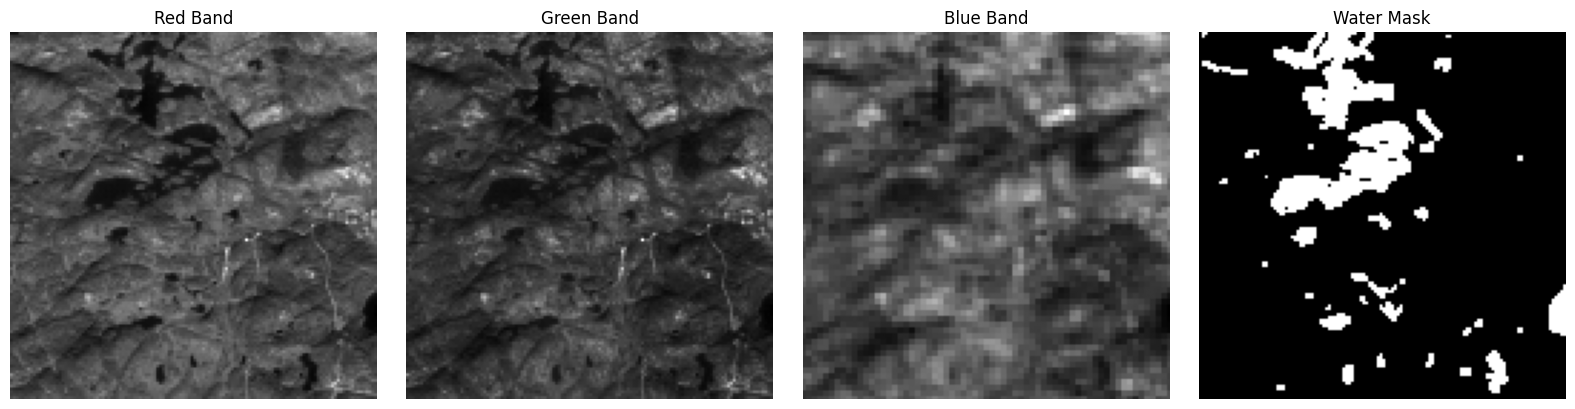

In [6]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from PIL import Image
import os

image_dir = "/content/data/filtered/images"
label_dir = "/content/data/filtered/labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

# Load a sample image (12-band .tif)
sample_img_path = os.path.join(image_dir, image_files[0])
with rasterio.open(sample_img_path) as src:
    img = src.read().astype('float32')
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

# Load corresponding binary mask
sample_mask_path = os.path.join(label_dir, label_files[0])
mask = np.array(Image.open(sample_mask_path)).astype('float32')
mask = (mask > 0).astype('float32')  # Ensure it's binary

# Show Red, Green, Blue bands + mask
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(img[2], cmap='gray'); axs[0].set_title("Red Band")
axs[1].imshow(img[1], cmap='gray'); axs[1].set_title("Green Band")
axs[2].imshow(img[0], cmap='gray'); axs[2].set_title("Blue Band")
axs[3].imshow(mask, cmap='gray'); axs[3].set_title("Water Mask")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


In [7]:
from torch.utils.data import Dataset
import torch
import numpy as np
import rasterio
from PIL import Image
import os

class WaterSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))  # Ensure images and masks match by order
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        # Total number of image-mask pairs
        return len(self.image_files)

    def __getitem__(self, idx):
        # -------- Load multispectral image (.tif) --------
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        with rasterio.open(img_path) as src:
            image = src.read().astype('float32')  # Output shape: (12, H, W)

        # -------- Normalize image to [0, 1] range --------
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image = np.clip(image, 0, 1)  # Ensure values are bounded

        # -------- Load and binarize mask --------
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        mask = np.array(Image.open(mask_path)).astype('float32')  # Convert to float32
        mask = (mask > 0).astype('float32')  # Binary mask: water = 1, non-water = 0
        mask = np.expand_dims(mask, axis=0)  # Shape: (1, H, W)

        # -------- Apply augmentations if provided --------
        if self.transform:
            # Transpose image to (H, W, C) for albumentations
            augmented = self.transform(image=image.transpose(1, 2, 0), mask=mask.squeeze())
            image = augmented['image']            # Tensor with shape: (C, H, W)
            mask = augmented['mask'].unsqueeze(0) # Restore mask shape to: (1, H, W)

        return image, mask  # Both as torch tensors


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split

# Define data augmentations for training set (helps prevent overfitting)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),        # Randomly flip image horizontally with 50% chance
    A.VerticalFlip(p=0.5),          # Randomly flip image vertically with 50% chance
    A.RandomRotate90(p=0.5),        # Random 90-degree rotation with 50% chance
    ToTensorV2()                    # Convert image and mask to PyTorch tensors
])

# Validation set gets no augmentations (just converted to tensor)
val_transform = A.Compose([
    ToTensorV2()
])

# Paths to filtered images and masks
image_dir = "/content/data/filtered/images"
mask_dir = "/content/data/filtered/labels"

# Load the full dataset (transforms will be assigned after splitting)
full_dataset = WaterSegmentationDataset(image_dir, mask_dir, transform=None)

# Split the dataset: 80% for training, 20% for validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Assign the appropriate transform to each split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create PyTorch DataLoaders for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Confirm data readiness
print(f"Data ready: {len(train_dataset)} train, {len(val_dataset)} val")


Data ready: 208 train, 53 val


In [9]:
import segmentation_models_pytorch as smp
import torch

# Select device: Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the U-Net model for segmentation
model = smp.Unet(
    encoder_name="resnet34",        # Backbone encoder for feature extraction (ResNet-34)
    encoder_weights="imagenet",     # Load pretrained weights to help model converge faster
    in_channels=12,                 # Our input images have 12 spectral channels (not RGB)
    classes=1                       # Binary output: 1 channel (water vs. background)
).to(device)                        # Move model to the selected device (GPU/CPU)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [10]:
import torch.nn as nn

# Loss function for binary segmentation
# Combines a sigmoid layer and the binary cross-entropy loss in one function
loss_fn = nn.BCEWithLogitsLoss()  # Suitable for binary classification (e.g., water vs no water)

# Optimizer: Adam is widely used for segmentation tasks due to adaptive learning rates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler: reduces LR when validation loss stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,             # Optimizer to update
    mode='min',            # Minimize the validation loss
    patience=3,            # Wait 3 epochs without improvement
    factor=0.5,            # Reduce LR by a factor of 0.5
    verbose=True           # Print update messages
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
#8
def train_one_epoch(model, dataloader, optimizer, loss_fn):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()         # Reset gradients
        outputs = model(images)       # Forward pass
        loss = loss_fn(outputs, masks)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()  # Accumulate loss

    return running_loss / len(dataloader)  # Return average loss for the epoch


def validate(model, dataloader, loss_fn):
    model.eval()  # Set model to evaluation mode (no dropout, no batchnorm update)
    running_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    n = 0  # Batch counter

    with torch.no_grad():  # Disable gradient computation for validation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)           # Forward pass
            loss = loss_fn(outputs, masks)    # Compute validation loss

            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions

            # Compute IoU (Intersection over Union)
            intersection = (preds & masks.bool()).float().sum((1, 2, 3))
            union = (preds | masks.bool()).float().sum((1, 2, 3))
            iou = (intersection / (union + 1e-8)).mean().item()

            # Compute F1 Score (Dice coefficient)
            f1 = (2 * intersection / (preds.sum((1, 2, 3)) + masks.sum((1, 2, 3)) + 1e-8)).mean().item()

            # Accumulate metrics
            running_loss += loss.item()
            total_iou += iou
            total_f1 += f1
            n += 1

    # Return average validation loss, IoU, and F1 score
    return running_loss / n, total_iou / n, total_f1 / n


In [12]:
import copy

# Training configuration
num_epochs = 30                 # Total number of epochs to train
best_val_loss = float("inf")   # Initialize best validation loss with a large number
patience = 5                   # Early stopping patience (stop if no improvement for 5 epochs)
patience_counter = 0           # Counter to track lack of improvement

# Save the initial model weights as a backup
best_model_wts = copy.deepcopy(model.state_dict())

# Training loop
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)       # Train one epoch
    val_loss, val_iou, val_f1 = validate(model, val_loader, loss_fn)            # Validate after epoch

    scheduler.step(val_loss)  # Adjust learning rate if validation loss plateaus

    # Print metrics for the epoch
    print(f"\n Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # Save model if it improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())  # Save current model weights
        patience_counter = 0
        print("Best model updated!")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping.")  # Stop training early if no improvement
            break

# Load the best model weights after training ends
model.load_state_dict(best_model_wts)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 1/30
Train Loss: 0.5659
Val Loss:   0.4595 | IoU: 0.3745 | F1: 0.4802
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 2/30
Train Loss: 0.4216
Val Loss:   0.4080 | IoU: 0.3950 | F1: 0.4921
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 3/30
Train Loss: 0.3842
Val Loss:   0.3614 | IoU: 0.4654 | F1: 0.5653
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 4/30
Train Loss: 0.3366
Val Loss:   0.2919 | IoU: 0.4729 | F1: 0.5497
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 5/30
Train Loss: 0.3227
Val Loss:   0.2860 | IoU: 0.4806 | F1: 0.5704
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 6/30
Train Loss: 0.2998
Val Loss:   0.3183 | IoU: 0.4746 | F1: 0.5749
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 7/30
Train Loss: 0.2936
Val Loss:   0.3640 | IoU: 0.4586 | F1: 0.5426
No improvement. Patience: 2/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 8/30
Train Loss: 0.2699
Val Loss:   0.2912 | IoU: 0.4886 | F1: 0.5764
No improvement. Patience: 3/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 9/30
Train Loss: 0.2379
Val Loss:   0.2768 | IoU: 0.5065 | F1: 0.5887
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 10/30
Train Loss: 0.2342
Val Loss:   0.2770 | IoU: 0.5551 | F1: 0.6549
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 11/30
Train Loss: 0.2252
Val Loss:   0.2472 | IoU: 0.5414 | F1: 0.6313
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 12/30
Train Loss: 0.2187
Val Loss:   0.2408 | IoU: 0.5355 | F1: 0.6254
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 13/30
Train Loss: 0.1882
Val Loss:   0.2110 | IoU: 0.5892 | F1: 0.6807
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 14/30
Train Loss: 0.1944
Val Loss:   0.2791 | IoU: 0.5221 | F1: 0.6026
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 15/30
Train Loss: 0.1646
Val Loss:   0.2169 | IoU: 0.6008 | F1: 0.6917
No improvement. Patience: 2/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 16/30
Train Loss: 0.1853
Val Loss:   0.2552 | IoU: 0.5539 | F1: 0.6414
No improvement. Patience: 3/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 17/30
Train Loss: 0.1805
Val Loss:   0.2323 | IoU: 0.5801 | F1: 0.6690
No improvement. Patience: 4/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 18/30
Train Loss: 0.1599
Val Loss:   0.2109 | IoU: 0.6020 | F1: 0.6900
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 19/30
Train Loss: 0.1564
Val Loss:   0.2241 | IoU: 0.6072 | F1: 0.6978
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 20/30
Train Loss: 0.1413
Val Loss:   0.2079 | IoU: 0.6000 | F1: 0.6883
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 21/30
Train Loss: 0.1390
Val Loss:   0.2078 | IoU: 0.5893 | F1: 0.6748
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 22/30
Train Loss: 0.1381
Val Loss:   0.1981 | IoU: 0.6124 | F1: 0.7017
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 23/30
Train Loss: 0.1358
Val Loss:   0.2093 | IoU: 0.5872 | F1: 0.6715
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 24/30
Train Loss: 0.1468
Val Loss:   0.1933 | IoU: 0.6061 | F1: 0.6991
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 25/30
Train Loss: 0.1370
Val Loss:   0.2112 | IoU: 0.5972 | F1: 0.6872
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 26/30
Train Loss: 0.1167
Val Loss:   0.1959 | IoU: 0.6243 | F1: 0.7130
No improvement. Patience: 2/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 27/30
Train Loss: 0.1197
Val Loss:   0.1924 | IoU: 0.6168 | F1: 0.7046
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 28/30
Train Loss: 0.1152
Val Loss:   0.1976 | IoU: 0.6351 | F1: 0.7240
No improvement. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 29/30
Train Loss: 0.1090
Val Loss:   0.1921 | IoU: 0.6306 | F1: 0.7181
Best model updated!


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



 Epoch 30/30
Train Loss: 0.1287
Val Loss:   0.1964 | IoU: 0.6168 | F1: 0.7045
No improvement. Patience: 1/5


<All keys matched successfully>

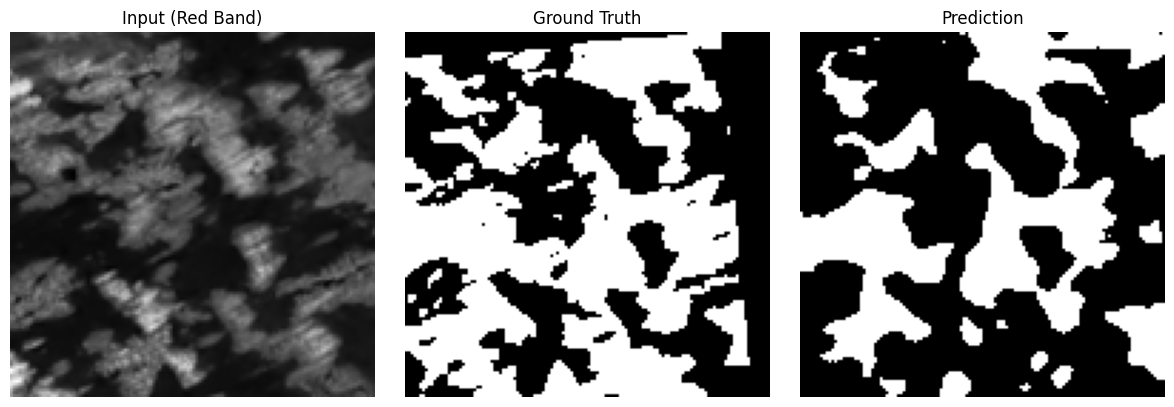

In [14]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, index=0):
    model.eval()
    image, mask = dataset[index]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image_input)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[2], cmap='gray')  # red band
    axs[0].set_title("Input (Red Band)")
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Prediction")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()


visualize_prediction(model, val_dataset, index=0)
